In [1]:
import numpy as np
from pathlib import Path
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import urllib
import json
import torch.optim as optim
import copy

In [2]:
!ln -s /Users/giakhang/Downloads/dataset_catdog .

In [ ]:
!unzip /Users/giakhang/Downloads/dataset_catdog.zip

In [3]:
BASE_PATH = "dataset_catdog"
TRAIN_PATH = 'training_set/training_set'
VALID_PATH = 'test_set/test_set'
TEST_PATH = 'test_set/test_set'
CLASSES = ['cat', 'dog']
IMG_PATH1= Path.cwd() / BASE_PATH / TEST_PATH / 'cats/cat.4001.jpg'
IMG_PATH2 = Path.cwd() / BASE_PATH / TEST_PATH / 'dogs/dog.4001.jpg'
IMG_SIZE = (224,224)

/Users/giakhang/py_venv/dl_huflit/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/giakhang/py_venv/dl_huflit/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Egyptian Mau: 0.3464
window screen: 0.3226
Siamese cat: 0.0597


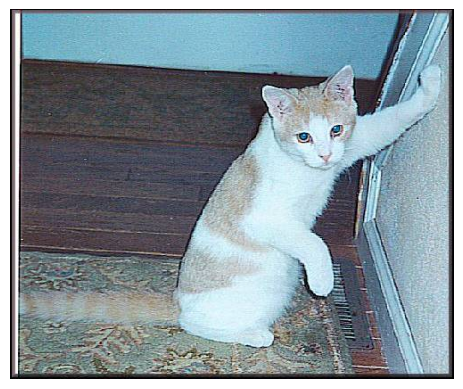

In [8]:
# Bước 1. Load model VGG16
model = models.vgg16(pretrained=True)
model.eval()

# Bước 2. Load ảnh + Tiền xử lý ảnh
# 2.1 Load ảnh
IMG_SIZE = (224, 224)
img = Image.open(IMG_PATH1).convert('RGB')

# 2.2 Tiền xử lý ảnh
preprocess = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
x = preprocess(img).unsqueeze(0)  # thêm chiều batch

# 2.3 Gọi hàm predict
with torch.no_grad():
    predictions = model(x)


# Get top 3 class predictions
topk = 3
_, indices = torch.topk(predictions, topk)
probs = torch.nn.functional.softmax(predictions, dim=1)[0]  # Apply softmax to get probabilities
top3_probs = probs[indices[0]]
top3_indices = indices[0]

# Download ImageNet class labels
url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
response = urllib.request.urlopen(url)
labels = json.loads(response.read())

# Decode predictions
top3_classes = [(labels[idx], top3_probs[i].item()) for i, idx in enumerate(top3_indices)]

# Print top 3 predictions
for label, score in top3_classes:
    print(f"{label}: {score:.4f}")

# Display the image
import matplotlib.pyplot as plt
plt.imshow(img)
plt.axis('off')
plt.show()


In [7]:
print(len(predictions[0]))

1000


In [9]:
import os
import numpy as np
from pathlib import Path
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

BASE_PATH = "dataset_catdog"
TRAIN_PATH = 'training_set/training_set'
VALID_PATH = 'test_set/test_set'
TEST_PATH = 'test_set/test_set'
CLASSES = ['cat', 'dog']

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load datasets
train_dataset = datasets.ImageFolder(root=Path.cwd() / BASE_PATH / TRAIN_PATH, transform=transform)
validation_dataset = datasets.ImageFolder(root=Path.cwd() / BASE_PATH / VALID_PATH, transform=transform)
test_dataset = datasets.ImageFolder(root=Path.cwd() / BASE_PATH / TEST_PATH, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Print batch shapes
for images_batch, labels_batch in train_loader:
    print("images batch shape:", images_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

images batch shape: torch.Size([32, 3, 224, 224])
labels batch shape: torch.Size([32])


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_Cat_Dog(nn.Module):
    def __init__(self):
        super(CNN_Cat_Dog, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=64 * 54 * 54, out_features=128)  # Adjust in_features based on input size
        self.fc2 = nn.Linear(in_features=128, out_features=2)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        return x

# Create the model
model = CNN_Cat_Dog()

In [7]:
device = torch.device("cuda" if torch.backends.mps.is_available() else "cpu")

# Create the model
model = CNN_Cat_Dog().to(device)
print(model)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 1
best_model_wts = copy.deepcopy(model.state_dict())
best_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device).float(), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")
    
    # Validation
    model.eval()
    val_loss = 0.0
    val_corrects = 0
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(device).float(), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)
    
    val_loss = val_loss / len(validation_loader.dataset)
    val_acc = val_corrects / len(validation_loader.dataset)
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")
    
    # Save best model
    if val_loss < best_loss:
        best_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())

# Load best model weights
model.load_state_dict(best_model_wts)
torch.save(model.state_dict(), "convnet_from_scratch.pth")

CNN_Cat_Dog(
  (rescale): Identity()
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=186624, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)
Epoch 1/1, Loss: 0.8082
Validation Loss: 0.8135, Accuracy: 0.4998


In [8]:
model = CNN_Cat_Dog()
model.load_state_dict(torch.load("convnet_from_scratch.pth"))
model.eval()

# Move the model to the device
device = torch.device("cuda" if torch.backends.mps.is_available() else "cpu")
model.to(device)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_dataset = datasets.ImageFolder(root=Path.cwd() / BASE_PATH / TEST_PATH, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Evaluate the model on the test dataset
test_loss = 0.0
test_corrects = 0
criterion = nn.CrossEntropyLoss()

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device).float(), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        test_corrects += torch.sum(preds == labels.data)

test_loss = test_loss / len(test_loader.dataset)
test_acc = test_corrects / len(test_loader.dataset)
print(f"Test accuracy: {test_acc:.3f}")

Test accuracy: 0.500


In [12]:
import torchvision.transforms as transforms

data_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),  # 0.1 * 360 degrees
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0))  # Simulates zoom by cropping and resizing
])

# Example usage with a dataset
transform = transforms.Compose([
    data_augmentation,
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Apply the transform to an image dataset
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader


train_dataset = ImageFolder(root=Path.cwd() / BASE_PATH / TRAIN_PATH, transform=transform)
data_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [14]:
class VGG_FeatureExtraction(nn.Module):
    def __init__(self):
        super(VGG_FeatureExtraction, self).__init__()
        
        # Data augmentation
        self.data_augmentation = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),  # 0.1 * 360 degrees
            transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0))  # Simulates zoom by cropping and resizing
        ])
        
        # Load VGG16 model
        self.conv_base = models.vgg16(pretrained=True).features
        
        # Freeze layers until 'block4_conv3'
        freeze_until_layer = 'features.23'  # Corresponds to 'block4_conv3' in PyTorch
        for name, param in self.conv_base.named_parameters():
            param.requires_grad = False
            if name == freeze_until_layer + '.weight':
                break
        
        # Additional layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512 * 7 * 7, 128)  # Adjust in_features based on input size
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 2)
        
    def forward(self, x):
        x = self.data_augmentation(x)
        x = self.conv_base(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.softmax(self.fc2(x), dim=1)
        return x

# Create the model
model = VGG_FeatureExtraction()

# Move the model to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

VGG_FeatureExtraction(
  (conv_base): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, pa

In [19]:
import os

model = VGG_FeatureExtraction()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "mps"
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define datasets and dataloaders
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Training loop with model checkpointing
num_epochs = 1
best_val_loss = float('inf')
checkpoint_path = "convnet_from_scratch.pth"

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_corrects = 0
    
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)
    
    val_loss = val_loss / len(validation_loader.dataset)
    val_acc = val_corrects.double() / len(validation_loader.dataset)
    
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
    
    # Save the model if validation loss has decreased
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), checkpoint_path)

Epoch 1/1, Loss: 0.3533, Accuracy: 0.9584
Validation Loss: 0.3329, Validation Accuracy: 0.9797
